In [21]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from torch.autograd import Variable
import torch
import torch.optim as optim

from autograd.core import primitive
import tensorflow as tf
import math as mat

from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
nx = 50
dx = 1. / nx
# W = [npr.randn(1, 10), npr.randn(10, 1)]
x_space = Variable(torch.linspace(-1, 1, nx),requires_grad=False)    

In [10]:
inf_s = 1e-3
y_0 = 1

# Sigmoid  activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# sigmoid derivative
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))


# tanh derivative
def tanh_grad(x):
    return 4/(torch.exp(x)+torch.exp(-x))**2

# tanh activation function
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))


# LeakyReLU activation
def leakyReLU(x):
  return torch.where(x > 0.0, x, x * 0.01)

# Leaky ReLU derivative
def leakyReLU_grad(x):
  return torch.where(x > 0.0, 1.0, 0.01)


# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and sigmoid activation
# def neural_network(W, x, b):
#      a1 = sigmoid(torch.mul(W[0],x) + b)
#      return torch.dot(torch.flatten(a1), torch.flatten(W[1]))


# This function takes the derivative of Neural Network output w.r.t 't'
# def d_neural_network_dx(W, x, k=1):
#     return (neural_network(W, x + inf_s) - neural_network(W, x))/inf_s

# derivative of NN analytical with sigmoid activation
# def d_neural_network_dx(W, x, b, k=1):
#     return torch.dot(torch.flatten(sigmoid_grad(torch.mul(W[0],x) + b)) , torch.flatten(torch.transpose(W[0],0,1).mul(W[1])))

# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and tanh activation
def neural_network(W, x, b):
     a1 = tanh(torch.mul(W[0],x) + b)
     return torch.dot(torch.flatten(a1), torch.flatten(W[1]))


# derivative of NN analytical with tanh activation
def d_neural_network_dx(W, x, b, k=1):
    return torch.dot(torch.flatten(tanh_grad(torch.mul(W[0],x) + b)) , torch.flatten(torch.transpose(W[0],0,1).mul(W[1])))


# # neural network with ReLU activation
# def neural_network(W, x, b):
#      a1 = leakyReLU(torch.mul(W[0],x) + b)
#      return torch.dot(torch.flatten(a1), torch.flatten(W[1]))

# # neural network derivative with ReLU activation 
# def d_neural_network_dx(W, x, b, k=1):
#     return torch.dot(torch.flatten(leakyReLU_grad(torch.mul(W[0].float(),x.float()) + b.float())) , torch.flatten(torch.transpose(W[0].float(),0,1).mul(W[1].float())))



In [4]:
# Calculate the MSE for the differential equation 1
def get_errSqr_x(x_T, y_T, d_x_T):
    return (d_x_T - x_T - y_T)**2

# Calculate the MSE for the differential equation 2
def get_errSqr_y(x_T, y_T, d_y_T):
    return (d_y_T - 4*x_T - y_T)**2

In [16]:
# This is the custom loss function where I calculate the 
def loss_function(W, x, epoch, b):
    loss_sum = 0.
    for xi in x:
        W_x = W[0]
        W_y = W[1]
        # net_out_x = neural_network(W_x, xi)[0][0]
        # net_out_y = neural_network(W_y, xi)[0][0]
        net_out_x = neural_network(W_x, xi, b[0][0])
        net_out_y = neural_network(W_y, xi, b[1][0])
        # d_net_out_x = d_neural_network_dx(W_x, xi)[0][0]
        # d_net_out_y = d_neural_network_dx(W_y, xi)[0][0]
        d_net_out_x = d_neural_network_dx(W_x, xi, b[0][0])
        d_net_out_y = d_neural_network_dx(W_y, xi, b[1][0])
        x_T = xi*net_out_x
        y_T = y_0 + xi*net_out_y
        d_x_T = net_out_x + xi*d_net_out_x
        d_y_T = net_out_y + xi*d_net_out_y
       
        # Calculating errors individually from the two differential equations
        err_sqr_x = get_errSqr_x(x_T, y_T, d_x_T)
        err_sqr_y = get_errSqr_y(x_T, y_T, d_y_T)
        err_sqr = err_sqr_x + err_sqr_y
        loss_sum += err_sqr
    print("epoch-->>",epoch, loss_sum)
    return loss_sum

In [36]:
# Initializing velocity for momentum with gradient desent
velocity_x_0 = torch.zeros((1,20))
velocity_x_1 = torch.zeros((20,1))

velocity_y_0 = torch.zeros((1,20))
velocity_y_1 = torch.zeros((20,1))


# Weights initialization for 1 hidden layered network for Neural net NN_x and NN_y
W_x = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+10)), size = (1,10))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(10+1)), size = (10,1))), requires_grad=True)]
b_x = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+10)), size = (1,10))), requires_grad=True)]
W_y = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+10)), size = (1,10))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(10+1)), size = (10,1))), requires_grad=True)]
b_y = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+10)), size = (1,10))), requires_grad=True)]

W = [W_x,W_y]
b = [b_x,b_y]


lmb = 0.00001
u = 0.999


optimizer = optim.Adam([W[0][0], W[0][1], W[1][0], W[1][1], b[0][0], b[1][0]], lr=0.01)

for i in range(1500):
    
    optimizer.zero_grad()
    loss = loss_function(W, x_space, i, b)

    # This function will calculate the gradient of loss function w.r.t all the weights for which the requires_grad is set to true
    # and save the calculated gradient in w[i].grad.data where w[i] is the ith weight in the weight array 

    loss.backward()

    optimizer.step()

    # updating the weights for Neural net NN_x
    # velocity_x_0 = u*velocity_x_0 - lmb*temp_Wt_x[0].grad.data
    # velocity_x_1 = u*velocity_x_1 - lmb*temp_Wt_x[1].grad.data

    # temp_Wt_x[0].data = temp_Wt_x[0].data + velocity_x_0
    # temp_Wt_x[1].data = temp_Wt_x[1].data + velocity_x_1


    # # updating the weights for neural net NN_y
    # velocity_y_0 = u*velocity_y_0 - lmb*temp_Wt_y[0].grad.data
    # velocity_y_1 = u*velocity_y_1 - lmb*temp_Wt_y[1].grad.data

    # temp_Wt_y[0].data = temp_Wt_y[0].data + velocity_y_0
    # temp_Wt_y[1].data = temp_Wt_y[1].data + velocity_y_1

    # Setting the grad.data to zero before next iteration because otherwise it will add the grad to prev value
    W[0][0].grad.data.zero_()
    W[0][1].grad.data.zero_()
    W[1][0].grad.data.zero_()
    W[1][1].grad.data.zero_()
    b[0][0].grad.data.zero_()
    b[1][0].grad.data.zero_()

epoch-->> 0 tensor(173.2043, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 1 tensor(139.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 2 tensor(112.7546, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 3 tensor(93.8086, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 4 tensor(81.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 5 tensor(74.5498, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 6 tensor(71.9827, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 7 tensor(72.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 8 tensor(74.1294, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 9 tensor(76.2824, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 10 tensor(77.9761, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 11 tensor(78.7992, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 12 tensor(78.6484, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 13 tensor(77.6294, dtype=torch.floa

In [37]:
# Now the actual functions x(t) and y(t)  (here t is xi actually) 
res_x = [xi*neural_network(W_x, xi, b[0][0]) for xi in x_space]
res_y = [y_0 + (xi)*neural_network(W_y, xi, b[1][0]) for xi in x_space]

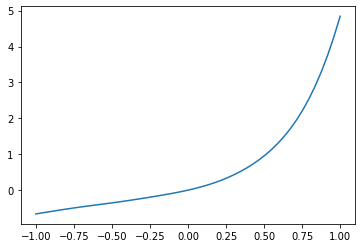

In [38]:
plt.plot(x_space, res_x)


[tensor(1.3726, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.3222, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.2743, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.2287, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.1856, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.1450, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.1068, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.0712, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.0382, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(1.0079, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.9803, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.9556, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.9338, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.9152, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.8998, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.8879, dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.8796, dtype=to

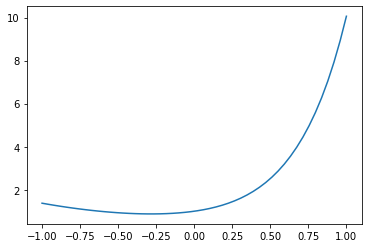

In [39]:
print(res_y)
plt.plot(x_space, res_y)